 7. Build your own CNN and try to achieve the highest possible accuracy on MNIST.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import ParameterGrid

In [2]:
mnist = tf.keras.datasets.mnist # load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data() # split dataset into training and testing sets
# normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0
# reshape the data for the convolutional neural network
x_train= x_train.reshape((-1,28,28,1)).astype('float32')
x_test= x_test.reshape((-1,28,28,1)).astype('float32')
# one hot encode the labels
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

In [3]:
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [4]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)


In [5]:
def create_model(filters=(32, 64, 64), dense_units=64, learning_rate=0.001): # function to create a model
    model = models.Sequential([
        layers.Conv2D(filters[0], (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters[1], (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters[2], (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
# Grid search for hyperparameters
param_grid = {
    'filters': [(32, 64, 64), (64, 128, 128)],
    'dense_units': [64, 128],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32,64, 128]
}
grid = ParameterGrid(param_grid)


In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
def train_and_evaluate(params):
    print(f"Training with params: {params}")
    model = create_model(filters=params['filters'], 
                         dense_units=params['dense_units'], 
                         learning_rate=params['learning_rate'])
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=params['batch_size']),
        validation_data=(x_test, y_test),
        epochs=5,
        callbacks=[early_stopping],
        verbose=2
    )
    _, test_acc = model.evaluate(x_test, y_test, verbose=0)
    return test_acc, model


In [9]:
# Run grid search
best_acc = 0
best_params = None
best_model = None

for params in grid:
    acc, model = train_and_evaluate(params)
    if acc > best_acc:
        best_acc = acc
        best_params = params
        best_model = model

print(f"Best Accuracy: {best_acc} with params: {best_params}")

# Save the best model
best_model.save('best_mnist_model.h5')

Training with params: {'batch_size': 32, 'dense_units': 64, 'filters': (32, 64, 64), 'learning_rate': 0.001}


Epoch 1/5


c:\Program Files\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Program Files\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 - 29s - 15ms/step - accuracy: 0.9153 - loss: 0.2704 - val_accuracy: 0.9833 - val_loss: 0.0510
Epoch 2/5
1875/1875 - 24s - 13ms/step - accuracy: 0.9725 - loss: 0.0893 - val_accuracy: 0.9885 - val_loss: 0.0336
Epoch 3/5
1875/1875 - 20s - 11ms/step - accuracy: 0.9791 - loss: 0.0669 - val_accuracy: 0.9895 - val_loss: 0.0312
Epoch 4/5
1875/1875 - 25s - 13ms/step - accuracy: 0.9819 - loss: 0.0598 - val_accuracy: 0.9923 - val_loss: 0.0231
Epoch 5/5
1875/1875 - 23s - 12ms/step - accuracy: 0.9844 - loss: 0.0500 - val_accuracy: 0.9921 - val_loss: 0.0234
Training with params: {'batch_size': 32, 'dense_units': 64, 'filters': (32, 64, 64), 'learning_rate': 0.0005}
Epoch 1/5
1875/1875 - 26s - 14ms/step - accuracy: 0.8845 - loss: 0.3692 - val_accuracy: 0.9785 - val_loss: 0.0737
Epoch 2/5
1875/1875 - 25s - 13ms/step - accuracy: 0.9615 - loss: 0.1246 - val_accuracy: 0.9874 - val_loss: 0.0398
Epoch 3/5
1875/1875 - 24s - 13ms/step - accuracy: 0.9728 - loss: 0.0872 - val_accuracy: 0.9908 - val_l

Best Accuracy: 0.9939000010490417 with params: {'batch_size': 64, 'dense_units': 64, 'filters': (64, 128, 128), 'learning_rate': 0.001}


# 8. Classifying large images using Inception v3.

a. Download some images of various animals. Load them in Python, for example
using the matplotlib.image.mpimg.imread() function. Resize and/or crop
them to 299 × 299 pixels, and ensure that they have just three channels (RGB),
with no transparency channel.

In [64]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

In [21]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [299, 299])  
    image = tf.image.grayscale_to_rgb(image) if image.shape[-1] == 1 else image  
    image = tf.cast(image, tf.float32) / 255.0 
    return image, label



In [36]:
path = kagglehub.dataset_download("andrewmvd/animal-faces")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Administrator\.cache\kagglehub\datasets\andrewmvd\animal-faces\versions\1


In [37]:
path = path + "/afhq/train"

In [38]:
training_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=7,
    horizontal_flip=True,
    zoom_range=0.2
)

In [39]:
dataset = training_generator.flow_from_directory(
    path,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 14630 images belonging to 3 classes.


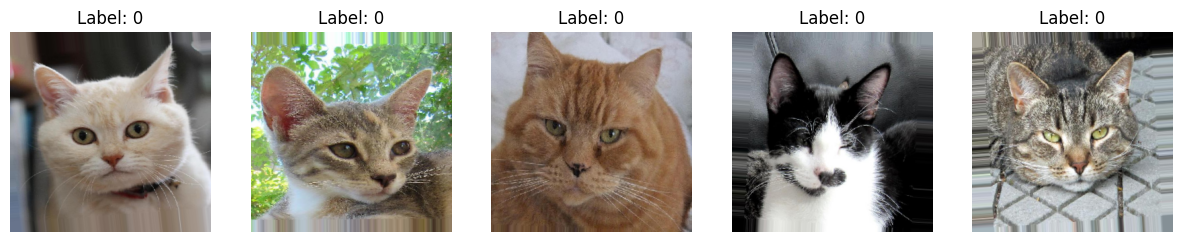

In [55]:
# Plot some images
batch_size = 5

images, labels = next(iter(dataset))

# Plot
plt.figure(figsize=(15, 15))
for i in range(batch_size):
    ax = plt.subplot(1, batch_size, i + 1)
    plt.imshow(images[i])  # Imagem já está normalizada entre 0 e 1
    plt.title(f"Label: {np.argmax(labels[i])}")  # Converter one-hot encoding para o índice da classe
    plt.axis("off")
plt.show()

b. Use the Pretrained Inception v3 Model from TensorFlow/Keras API

In [43]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [44]:
model = InceptionV3(weights="imagenet")
print("Pretrained model loaded successfully!")

Pretrained model loaded successfully!


d. Run the model to classify the images you prepared. Display the top five pre‐
dictions for each image, along with the estimated probability 

In [56]:
predictions = model.predict(images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


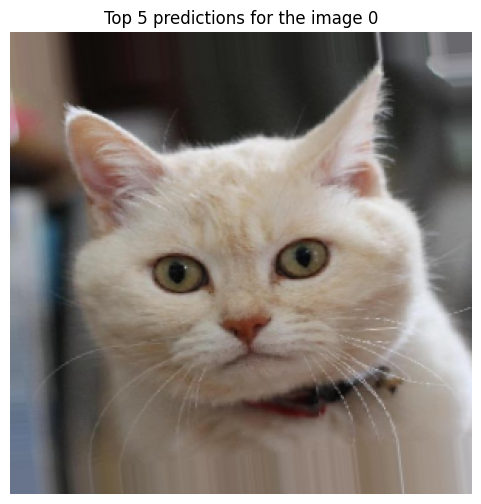

tabby: 0.2147
Persian_cat: 0.1881
tiger_cat: 0.0942
shower_curtain: 0.0217
Egyptian_cat: 0.0215




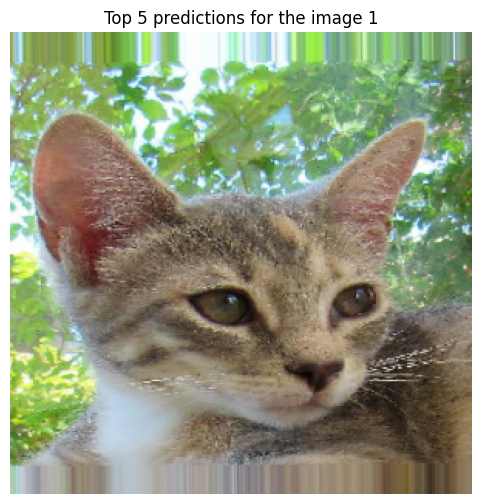

Egyptian_cat: 0.8366
tabby: 0.0523
tiger_cat: 0.0124
panpipe: 0.0072
lynx: 0.0015




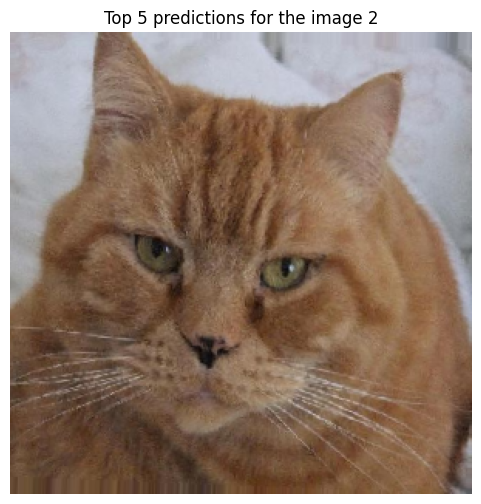

tiger_cat: 0.6116
tabby: 0.2506
Egyptian_cat: 0.0265
Persian_cat: 0.0096
lynx: 0.0048




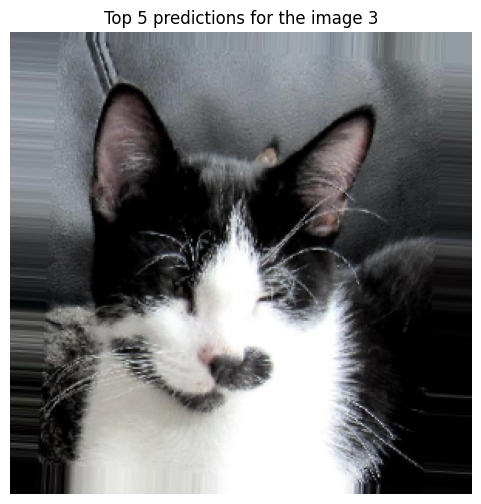

Egyptian_cat: 0.6350
tabby: 0.0743
Angora: 0.0443
tiger_cat: 0.0297
carton: 0.0146




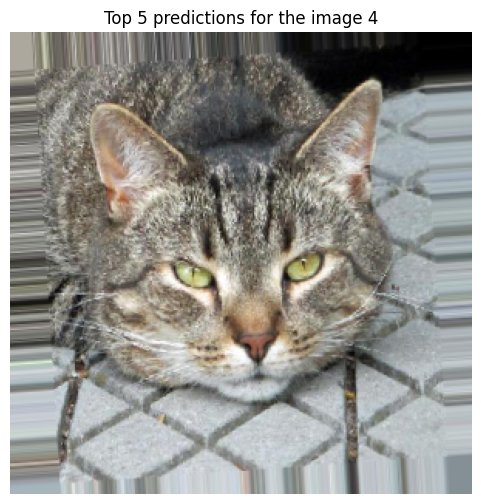

tabby: 0.5769
tiger_cat: 0.2700
Egyptian_cat: 0.0427
lynx: 0.0043
radiator: 0.0027




In [57]:
for i, pred in enumerate(predictions[:batch_size]):
    plt.figure(figsize=(6, 6))
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(f"Top 5 predictions for the image {i}")
    plt.show()
    
    for label, description, score in decode_predictions(np.expand_dims(pred, axis=0), top=5)[0]:
        print(f"{description}: {score:.4f}")
    print("\n")


# 9. Transfer learning for large image classification.


In [61]:
path = kagglehub.dataset_download("andrewmvd/animal-faces")
print("Path to dataset files:", path)
path = path + "/afhq"

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=7,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=path + '/train',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    directory=path + '/train',
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Path to dataset files: C:\Users\Administrator\.cache\kagglehub\datasets\andrewmvd\animal-faces\versions\1
Found 11706 images belonging to 3 classes.
Found 2924 images belonging to 3 classes.


In [62]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [63]:
base_model.trainable = False # Freeze the base model to retain pre-trained weights

In [66]:
# Add a new head to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)            
x = Dropout(0.3)(x)                       
x = Dense(1024, activation='relu')(x)      
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  


In [68]:
# Combine base model and new head
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 781s 4s/step - accuracy: 0.9978 - loss: 0.0110 - val_accuracy: 0.9951 - val_loss: 0.0156
Epoch 2/10
  1/182 ━━━━━━━━━━━━━━━━━━━━ 9:42 3s/step - accuracy: 1.0000 - loss: 0.0019

c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 771s 4s/step - accuracy: 0.9981 - loss: 0.0065 - val_accuracy: 0.9986 - val_loss: 0.0061
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 1.0000 - loss: 3.9244e-04 - val_accuracy: 1.0000 - val_loss: 6.8494e-04
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 766s 4s/step - accuracy: 0.9964 - loss: 0.0099 - val_accuracy: 0.9986 - val_loss: 0.0051
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 1.0000 - loss: 7.4873e-04 - val_accuracy: 1.0000 - val_loss: 1.8118e-04
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 765s 4s/step - accuracy: 0.9979 - loss: 0.0057 - val_accuracy: 0.9976 - val_loss: 0.0105
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 1.0000 - loss: 4.8179e-05 - val_accuracy: 1.0000 - val_loss: 1.7340e-04
Epoch 9/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 768s 4s/step - accuracy: 0.9977 - loss: 0.01

In [72]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.9967 - loss: 0.0092
Validation Loss: 0.0065
Validation Accuracy: 0.9973


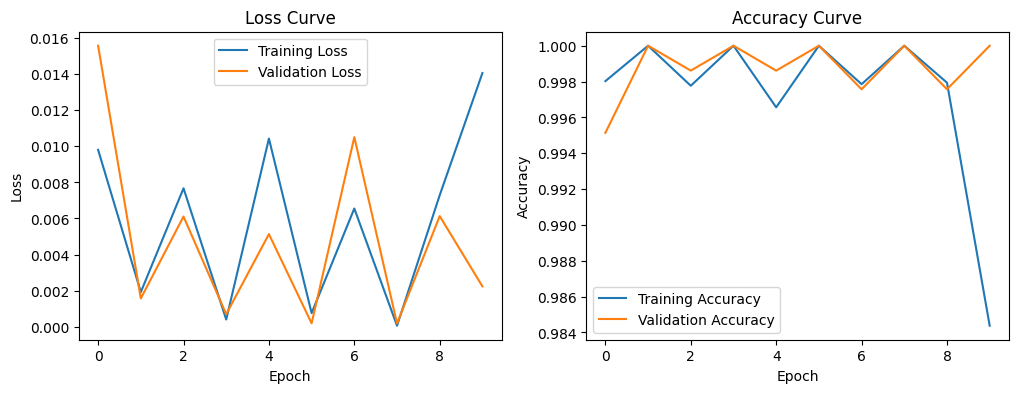

In [75]:
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
